
# Упражнение 27.1 — Морфлинг из Dota 2

Характеристики героя Morphling из игры Dota 2 (сила Сил и ловкость Лов) рассчитываются в зависимости от уровня `ур` как:

```
Сил = 23 + 3.2 × ур  
Лов = 24 + 3.9 × ур
```

Броня рассчитывается как:
```
Б = Б_баз + (1/6) × Лов
```
где Б — суммарная броня, Б_баз = -2 — базовая броня. Для любого значения брони, множитель урона определяется как:
```
У_мн = 1 − (f × Б) / (b + f × |Б|)
```
где У_мн — множитель урона и Б — значение брони. База формулы брони `b = 1`, фактор формулы брони `f = 0.06`.

Эффективное здоровье против физического урона определяется как:
```
Э_з = Т_зд / У_мн
```
где Т_зд — текущее здоровье и У_мн — множитель урона. Текущее здоровье зависит от показателя силы персонажа:
```
Т_зд = 120 + 22 × Сил
```

Особенностью героя Morphling является то, что он может перекачивать все свои очки силы в ловкость и наоборот в соотношении 1 к 1. Регенерация здоровья зависит от силы. Одно очко силы увеличивает восстановление здоровья на 0.1 единицу в секунду.

Число атак в секунду зависит от:
```
Атк/с = (100 + Лов) / (100 × БВА)
```
где БВА — базовое время атаки `БВА = 1.5` с. Наносимый урон за одну атаку зависит от ловкости:
```
У = 18 + Лов
```

---

## Задания:

1. Построить график максимального эффективного здоровья и соответствующего ему количества перекаченных очков в зависимости от уровня.

2. Вы сражаетесь 1 на 1 с персонажем, у которого 1500 эффективного здоровья и 100 урона.  
   Определите количество перекаченных очков для минимизации времени победы, при условии, что ваш персонаж должен выжить.


In [17]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
!pip install nbformat 

# Константы
B_baz_const = -2
b_armor_formula_const = 1
f_armor_formula_const = 0.06
BVA_const = 1.5

# Расчет характеристик Морфлинга
def calculate_morphling_stats(ur, p_shifted):
    Sil_base = 23 + 3.2 * ur
    Lov_base = 24 + 3.9 * ur

    Sil = Sil_base - p_shifted
    Lov = Lov_base + p_shifted

    B = B_baz_const + (1/6) * Lov
    denominator_U_Mn = b_armor_formula_const + f_armor_formula_const * abs(B)
    denominator_U_Mn = max(denominator_U_Mn, 1e-9)
    U_Mn = 1 - (f_armor_formula_const * B) / denominator_U_Mn

    T_Zd = 120 + 22 * Sil

    if abs(U_Mn) < 1e-9:
        EHP = float('inf') if T_Zd > 0 else 0
    else:
        EHP = T_Zd / U_Mn
    if np.isfinite(EHP) and EHP < 0 and U_Mn < 0:
        EHP = -float('inf')

    Atk_per_s = (100 + Lov) / (100 * BVA_const)
    U_attack = 18 + Lov
    DPS = U_attack * Atk_per_s
    HP_regen = 0.1 * Sil

    return {
        "valid": True, "Sil": Sil, "Lov": Lov, "B": B, "U_Mn": U_Mn,
        "T_Zd": T_Zd, "EHP": EHP, "Atk_per_s": Atk_per_s,
        "U_attack": U_attack, "DPS": DPS, "HP_regen": HP_regen
    }

# Часть 1: Максимизация EHP
def solve_part1(max_level=30):
    results = []
    for ur in range(1, max_level + 1):
        Sil_base = 23 + 3.2 * ur
        Lov_base = 24 + 3.9 * ur

        p_min = int(np.ceil(1 - Lov_base))
        p_max = int(np.floor(Sil_base - 1))

        max_EHP = -float("inf")
        best_p, best_Sil, best_Lov = None, None, None

        for p in range(p_min, p_max + 1):
            stats = calculate_morphling_stats(ur, p)
            if stats["valid"] and np.isfinite(stats["EHP"]) and stats["EHP"] > max_EHP:
                max_EHP = stats["EHP"]
                best_p, best_Sil, best_Lov = p, stats["Sil"], stats["Lov"]

        results.append({
            "level": ur, "max_EHP": max_EHP, "best_p_shifted": best_p,
            "Sil_at_max_EHP": best_Sil, "Lov_at_max_EHP": best_Lov
        })
    return pd.DataFrame(results)

# Часть 2: Оптимизация боя
def solve_part2(ur_fight, EHP_opponent, Damage_opponent_DPS):
    Sil_base = 23 + 3.2 * ur_fight
    Lov_base = 24 + 3.9 * ur_fight

    p_min = int(np.ceil(1 - Lov_base))
    p_max = int(np.floor(Sil_base - 1))

    min_TTK = float("inf")
    best_p = None
    best_stats = None
    TTK_O_kills_M = None

    for p in range(p_min, p_max + 1):
        stats = calculate_morphling_stats(ur_fight, p)
        TTK_M_kills_O = EHP_opponent / stats["DPS"]
        TTK_O_kills_M_cur = stats["EHP"] / Damage_opponent_DPS

        if TTK_M_kills_O < TTK_O_kills_M_cur:
            if TTK_M_kills_O < min_TTK:
                min_TTK = TTK_M_kills_O
                best_p = p
                best_stats = stats
                TTK_O_kills_M = TTK_O_kills_M_cur

    return {
        "message": f"Оптимальная стратегия найдена для уровня {ur_fight}.",
        "best_p_shifted": best_p,
        "min_TTK": min_TTK,
        "stats_at_best_TTK": best_stats,
        "TTK_O_kills_M_at_opt": TTK_O_kills_M
    }

# Пример запуска
if __name__ == "__main__":
    results_part1 = solve_part1(30)
    results_part2 = solve_part2(30, 1500, 100)
    print(results_part1.head())
    print(results_part2)


   level      max_EHP  best_p_shifted  Sil_at_max_EHP  Lov_at_max_EHP
0      1  1161.820632             -26            52.2             1.9
1      2  1305.924917             -30            59.4             1.8
2      3  1449.813930             -34            66.6             1.7
3      4  1593.488742             -38            73.8             1.6
4      5  1736.950413             -42            81.0             1.5
{'message': 'Оптимальная стратегия найдена для уровня 30.', 'best_p_shifted': 118, 'min_TTK': 2.2626026970224147, 'stats_at_best_TTK': {'valid': True, 'Sil': 1.0, 'Lov': 259.0, 'B': 41.166666666666664, 'U_Mn': 0.2881844380403459, 'T_Zd': 142.0, 'EHP': 492.7399999999999, 'Atk_per_s': 2.3933333333333335, 'U_attack': 277.0, 'DPS': 662.9533333333334, 'HP_regen': 0.1}, 'TTK_O_kills_M_at_opt': 4.927399999999999}



# Решение задачи про Морфлинга

## Общая идея

Наша цель — оптимизировать характеристики Морфлинга, зависящие от его уровня и перераспределения очков между Силой и Ловкостью.

### Задание 1 — Максимизация Эффективного Здоровья (EHP)

Для каждого уровня `ур` от 1 до 30:
1. Вычисляем базовые значения Силы и Ловкости.
2. Определяем допустимый диапазон перераспределения очков `p`, где:
   - `Сил = Сил_баз - p`
   - `Лов = Лов_баз + p`
   - Ограничения: `Сил > 0`, `Лов > 0`
3. Для каждого `p` в этом диапазоне считаем:
   - Броню `Б`
   - Множитель урона `У_мн`
   - Текущее здоровье `Т_зд`
   - Эффективное здоровье `Э_з = Т_зд / У_мн`
4. Запоминаем наилучшее значение `p`, дающее максимальное `Э_з`.

### Задание 2 — Сражение 1 на 1

Параметры противника заданы:
- Эффективное здоровье = 1500
- Урон в секунду = 100

Для текущего уровня:
1. Аналогично подбираем `p` в допустимом диапазоне.
2. Вычисляем урон в секунду Морфлинга:
   - `DPS = (18 + Лов) × ((100 + Лов) / (100 × 1.5))`
3. Считаем:
   - Время убийства врага `TTK_Morph = 1500 / DPS`
   - Время, за которое убьют Морфлинга `TTK_Enemy = EHP / 100`
4. Среди `p`, при которых Морфлинг успевает убить врага раньше, чем умрет сам, выбираем минимальное `TTK_Morph`.

## Вывод

Подход базируется на переборе допустимых значений перераспределения очков с симуляцией параметров, вычислением EHP и DPS, и сравнением времён убийства.


In [18]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize


target_df = pd.read_csv("target.csv")
value_df = pd.read_csv("value.csv")

p = len(target_df)
q = 20
a = target_df['MaxWeapon'].values
alpha_mat = target_df.iloc[:, 3:].values.astype(float)
alpha_mat[1, 1] = 0.83
b = np.where(pd.isna(value_df['MinWeapon']), 0, value_df['MinWeapon']).astype(float)
u = value_df['Value'].values

def objective(x):
    X = x.reshape(p, q)
    total_damage = 0
    for j in range(q):
        log_terms = X[:, j] * np.log(alpha_mat[:, j] + 1e-10)
        prod_term = np.sum(log_terms)
        damage_j = u[j] * (1 - np.exp(prod_term))
        total_damage += damage_j
    return -total_damage

def constraint_func(x):
    X = x.reshape(p, q)
    constraints = []
    
    for i in range(p):
        constraints.append(a[i] - np.sum(X[i, :]))
    
    for j in range(q):
        constraints.append(np.sum(X[:, j]) - b[j])
    
    return np.array(constraints)

x0 = np.zeros(p * q)
for j in range(q):
    for i in range(p):
        x0[i * q + j] = b[j] / p

bounds = [(0, None) for _ in range(p * q)]

constraints = {'type': 'ineq', 'fun': constraint_func}

result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints, 
                 options={'ftol': 1e-6, 'maxiter': 1000})

X_opt = result.x.reshape(p, q)

weapons_by_type = np.sum(X_opt, axis=1)
total_weapons = np.sum(weapons_by_type)
type_percentages = 100 * weapons_by_type / total_weapons

results_df = pd.DataFrame(X_opt, 
                         columns=[f'T{i+1}' for i in range(q)],
                         index=[f'W{i+1}' for i in range(p)])
results_df['Всего'] = weapons_by_type
results_df['Доля (%)'] = type_percentages

print("Оптимальное назначение вооружений по целям:")
print(results_df.round(2))

max_damage = -result.fun
print(f"\nМаксимальный ожидаемый урон: {max_damage:.2f}")

print(f"\nСтатус оптимизации: {result.success}")
print(f"Количество итераций: {result.nit}")

target_damage = []
for j in range(q):
    log_terms = X_opt[:, j] * np.log(alpha_mat[:, j] + 1e-10)
    prod_term = np.sum(log_terms)
    damage = u[j] * (1 - np.exp(prod_term))
    target_damage.append(damage)

damage_df = pd.DataFrame({
    'Target': [f'T{i+1}' for i in range(q)],
    'Value': u,
    'MinWeapon': b,
    'AssignedWeapons': np.sum(X_opt, axis=0),
    'ExpectedDamage': target_damage
})

print("\nУрон по целям:")
print(damage_df.round(2))

constraints_check = constraint_func(result.x)
print(f"\nПроверка ограничений (все должны быть >= 0):")
print(f"Минимальные значения ограничений: {np.min(constraints_check):.6f}")

Оптимальное назначение вооружений по целям:
      T1     T2    T3     T4     T5     T6     T7     T8     T9    T10  ...  \
W1   0.0  11.05   0.0   0.00   0.00  100.0  40.26  27.82  20.86   0.00  ...   
W2   0.0  17.77   0.0   0.00  21.65    0.0   0.00   0.00   0.00   0.00  ...   
W3   0.0   0.00   0.0   0.00   0.00    0.0   0.00   0.00   0.00   0.00  ...   
W4   0.0   0.00   0.0   0.00   0.00    0.0   0.00   0.00   0.00   0.00  ...   
W5  49.1   0.00  46.9  51.76   0.00    0.0   0.00   0.00   0.00  49.75  ...   

      T13    T14    T15    T16    T17    T18    T19    T20  Всего  Доля (%)  
W1   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  200.0      20.0  
W2   0.00   0.00  27.34  27.59   5.65   0.00   0.00   0.00  100.0      10.0  
W3   0.00   0.00  42.66   0.00  68.54  59.01  65.92  63.87  300.0      30.0  
W4   0.00  60.29   0.00  12.82   0.00   0.00   0.00   0.00  150.0      15.0  
W5  52.49   0.00   0.00   0.00   0.00   0.00   0.00   0.00  250.0      25.0  

[5 rows x 22

In [19]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize


target_df = pd.read_csv("target.csv")
value_df = pd.read_csv("value.csv")

p = len(target_df)
q = 20
c_vec = target_df['Cost'].values
alpha_mat = target_df.iloc[:, 3:].values.astype(float)
alpha_mat[1, 1] = 0.83

d = np.zeros(q)
target_indices = [0, 14, 18]
d[target_indices] = 0.99

def objective_cost(x):
    X = x.reshape(p, q)
    total_cost = np.sum(c_vec * np.sum(X, axis=1))
    return total_cost

def constraint_func_cost(x):
    X = x.reshape(p, q)
    constraints = []
    
    for j in range(q):
        log_terms = X[:, j] * np.log(alpha_mat[:, j] + 1e-10)
        prod_term = np.sum(log_terms)
        hit_prob = 1 - np.exp(prod_term)
        constraints.append(hit_prob - d[j])
    
    return np.array(constraints)

x0_cost = np.zeros(p * q)
for j in target_indices:
    for i in range(p):
        x0_cost[i * q + j] = 5

bounds_cost = [(0, None) for _ in range(p * q)]

constraints_cost = {'type': 'ineq', 'fun': constraint_func_cost}

result_cost = minimize(objective_cost, x0_cost, method='SLSQP', bounds=bounds_cost, 
                      constraints=constraints_cost, options={'ftol': 1e-8, 'maxiter': 3000})

X_opt_cost = result_cost.x.reshape(p, q)

weapons_totals = np.sum(X_opt_cost, axis=1)
weapons_costs = c_vec * weapons_totals

results_cost_df = pd.DataFrame(X_opt_cost, 
                              columns=[f'T{i+1}' for i in range(q)],
                              index=[f'W{i+1}' for i in range(p)])
results_cost_df['Всего единиц'] = weapons_totals
results_cost_df['Стоимость'] = weapons_costs

print("Оптимальное назначение оружия (минимальная стоимость):")
print(results_cost_df.round(2))

min_total_cost = result_cost.fun
print(f"\nМинимальная суммарная стоимость: {min_total_cost:.2f}")

print(f"\nСтатус оптимизации: {result_cost.success}")
print(f"Количество итераций: {result_cost.nit}")

hit_probabilities = []
for j in range(q):
    log_terms = X_opt_cost[:, j] * np.log(alpha_mat[:, j] + 1e-10)
    prod_term = np.sum(log_terms)
    hit_prob = 1 - np.exp(prod_term)
    hit_probabilities.append(hit_prob)

target_analysis = pd.DataFrame({
    'Target': [f'T{i+1}' for i in range(q)],
    'Required_Damage': d,
    'Achieved_Damage': hit_probabilities,
    'Assigned_Weapons': np.sum(X_opt_cost, axis=0),
    'Status': ['REQUIRED' if d[i] > 0 else 'Optional' for i in range(q)]
})

print("\nАнализ по целям:")
print(target_analysis.round(4))

constraints_check_cost = constraint_func_cost(result_cost.x)
print(f"\nПроверка ограничений (все должны быть >= 0):")
print(f"Минимальные значения ограничений: {np.min(constraints_check_cost):.6f}")

required_targets = target_analysis[target_analysis['Status'] == 'REQUIRED']
print(f"\nДостижение требований по обязательным целям:")
for _, row in required_targets.iterrows():
    print(f"{row['Target']}: {row['Achieved_Damage']:.4f} (требуется: {row['Required_Damage']:.2f})")

total_weapons_used = np.sum(weapons_totals)
print(f"\nОбщее количество использованного оружия: {total_weapons_used:.2f}")
print(f"Общая стоимость операции: {min_total_cost:.2f}")

Оптимальное назначение оружия (минимальная стоимость):
       T1   T2   T3   T4   T5   T6   T7   T8   T9  T10  ...  T13  T14    T15  \
W1   0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   0.00   
W2  26.41  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  33.07   
W3   0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   0.00   
W4   0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   0.00   
W5   0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   0.00   

    T16  T17  T18    T19  T20  Всего единиц  Стоимость  
W1  0.0  0.0  0.0   0.00  0.0          0.00       0.00  
W2  0.0  0.0  0.0  28.34  0.0         87.82   17563.49  
W3  0.0  0.0  0.0   0.00  0.0          0.00       0.00  
W4  0.0  0.0  0.0   0.00  0.0          0.00       0.00  
W5  0.0  0.0  0.0   0.00  0.0          0.00       0.00  

[5 rows x 22 columns]

Минимальная суммарная стоимость: 17563.49

Статус оптимизации: True
Количество итераций: 11

Анали

In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

total_parts = 239_600_480

fixed_A = 3_855.84
fixed_B = 125_804.84
fixed_C = 13_456.00
fixed_D = 6_583.98
fixed_E = 0

bound_A = 33_000_000
bound_B = 160_000_000
bound_C = 165_600_000
bound_D = 12_000_000
bound_E = 77_000_000

def cost_A(xA):
    if xA <= 0:
        return 0
    return fixed_A + 0.0061150 * xA

def cost_B(xB):
    if xB < 22_000_000:
        return 1e12
    if xB <= 70_000_000:
        return fixed_B + 0.068099 * xB
    elif xB <= 100_000_000:
        return fixed_B + 0.068099 * 70_000_000 + 0.066049 * (xB - 70_000_000)
    elif xB <= 150_000_000:
        return fixed_B + 0.068099 * 70_000_000 + 0.066049 * 30_000_000 + 0.064099 * (xB - 100_000_000)
    elif xB <= 160_000_000:
        return fixed_B + 0.068099 * 70_000_000 + 0.066049 * 30_000_000 + 0.064099 * 50_000_000 + 0.062119 * (xB - 150_000_000)
    else:
        return 1e12

def cost_C(xC):
    if xC <= 0:
        return 0
    return fixed_C + 0.06219 * xC

def cost_D(xD):
    if xD <= 0:
        return 0
    return fixed_D + 0.072488 * xD

def cost_E(xE):
    if xE <= 0:
        return 0
    if xE <= 42_000_000:
        return fixed_E + 0.070150 * xE
    else:
        return fixed_E + 0.070150 * 42_000_000 + 0.068150 * (xE - 42_000_000)

def objective_cost(x):
    xA, xB, xC, xD, xE = x
    total_cost = cost_A(xA) + cost_B(xB) + cost_C(xC) + cost_D(xD) + cost_E(xE)
    return total_cost

def eq_constraint(x):
    return np.sum(x) - total_parts

x0 = np.array([bound_A, 22_000_000, bound_C, bound_D, bound_E])
sum0 = np.sum(x0)
adjustment = total_parts - sum0

if adjustment > 0:
    x0[0] = min(x0[0] + adjustment, bound_A)
elif adjustment < 0:
    x0[0] = max(x0[0] + adjustment, 0)

bounds = [(0, bound_A), (0, bound_B), (0, bound_C), (0, bound_D), (0, bound_E)]

constraints = {'type': 'eq', 'fun': eq_constraint}

result = minimize(objective_cost, x0, method='SLSQP', bounds=bounds, constraints=constraints, 
                 options={'ftol': 1e-8, 'maxiter': 10000})

sol = result.x

costs = [cost_A(sol[0]), cost_B(sol[1]), cost_C(sol[2]), cost_D(sol[3]), cost_E(sol[4])]

sol_df = pd.DataFrame({
    'Поставщик': ['A', 'B', 'C', 'D', 'E'],
    'Закуплено': sol,
    'Доля': [f"{round(100 * x / np.sum(sol), 2)}%" for x in sol],
    'Стоимость': costs
})

sol_df['Количество деталей'] = sol_df['Закуплено'].apply(lambda x: f"{int(x):,}".replace(',', ' '))
sol_df['Стоимость форм'] = sol_df['Стоимость'].apply(lambda x: f"{x:,.2f}".replace(',', ' '))

print("Оптимальное распределение закупок по поставщикам:")
display_df = sol_df[['Поставщик', 'Количество деталей', 'Доля', 'Стоимость форм']].copy()
print(display_df.to_string(index=False))

total_cost = objective_cost(sol)
print(f"\nОбщая стоимость закупок: {total_cost:,.2f}".replace(',', ' '))

print(f"\nСтатус оптимизации: {result.success}")
print(f"Количество итераций: {result.nit}")

print(f"\nПроверка ограничения равенства:")
constraint_value = eq_constraint(sol)
print(f"Сумма закупок: {np.sum(sol):,.0f}".replace(',', ' '))
print(f"Требуемое количество: {total_parts:,}".replace(',', ' '))
print(f"Разность: {constraint_value:,.0f}".replace(',', ' '))

print(f"\nДетальная стоимость по поставщикам:")
for i, supplier in enumerate(['A', 'B', 'C', 'D', 'E']):
    if sol[i] > 0:
        print(f"Поставщик {supplier}: {costs[i]:,.2f}".replace(',', ' '))

print(f"\nПроверка ограничений по поставщикам:")
suppliers = ['A', 'B', 'C', 'D', 'E']
bounds_list = [bound_A, bound_B, bound_C, bound_D, bound_E]
for i, supplier in enumerate(suppliers):
    if sol[i] > 0:
        print(f"Поставщик {supplier}: {sol[i]:,.0f} / {bounds_list[i]:,} (использовано {100*sol[i]/bounds_list[i]:.1f}%)".replace(',', ' '))

if sol[1] >= 22_000_000:
    print(f"\nПоставщик B выполняет минимальное требование: {sol[1]:,.0f} >= 22,000,000".replace(',', ' '))
else:
    print(f"\nВНИМАНИЕ: Поставщик B НЕ выполняет минимальное требование!")

Оптимальное распределение закупок по поставщикам:
Поставщик Количество деталей   Доля Стоимость форм
        A                  0   0.0%           0.00
        B         22 000 000  8.03%   1 623 982.84
        C        163 081 484  59.5%  10 155 493.54
        D         12 000 000  4.38%     876 439.98
        E         77 000 000 28.09%   5 331 550.00

Общая стоимость закупок: 17 987 466.36

Статус оптимизации: False
Количество итераций: 2

Проверка ограничения равенства:
Сумма закупок: 274 081 485
Требуемое количество: 239 600 480
Разность: 34 481 005

Детальная стоимость по поставщикам:
Поставщик B: 1 623 982.84
Поставщик C: 10 155 493.54
Поставщик D: 876 439.98
Поставщик E: 5 331 550.00

Проверка ограничений по поставщикам:
Поставщик B: 22 000 000 / 160 000 000 (использовано 13.8%)
Поставщик C: 163 081 485 / 165 600 000 (использовано 98.5%)
Поставщик D: 12 000 000 / 12 000 000 (использовано 100.0%)
Поставщик E: 77 000 000 / 77 000 000 (использовано 100.0%)

Поставщик B выполняет м

=== ОДНОМЕРНАЯ РЕГРЕССИЯ ===

Исходные данные:
Количество точек: 101
X: от 0.000 до 10.000
F: от -0.433 до 10.181

Оптимизация с L2-нормой:
Оптимальные параметры: p1=2.118025, p2=2.969227, p3=0.721973
Сумма квадратов ошибок: 8.527930
Успешность оптимизации: True
Количество итераций: 21

Оптимизация с функцией потерь Хубера (δ=1.0):
Оптимальные параметры: p1=2.118025, p2=2.969227, p3=0.721973
Функция потерь Хубера: 4.263965
Успешность оптимизации: True
Количество итераций: 19


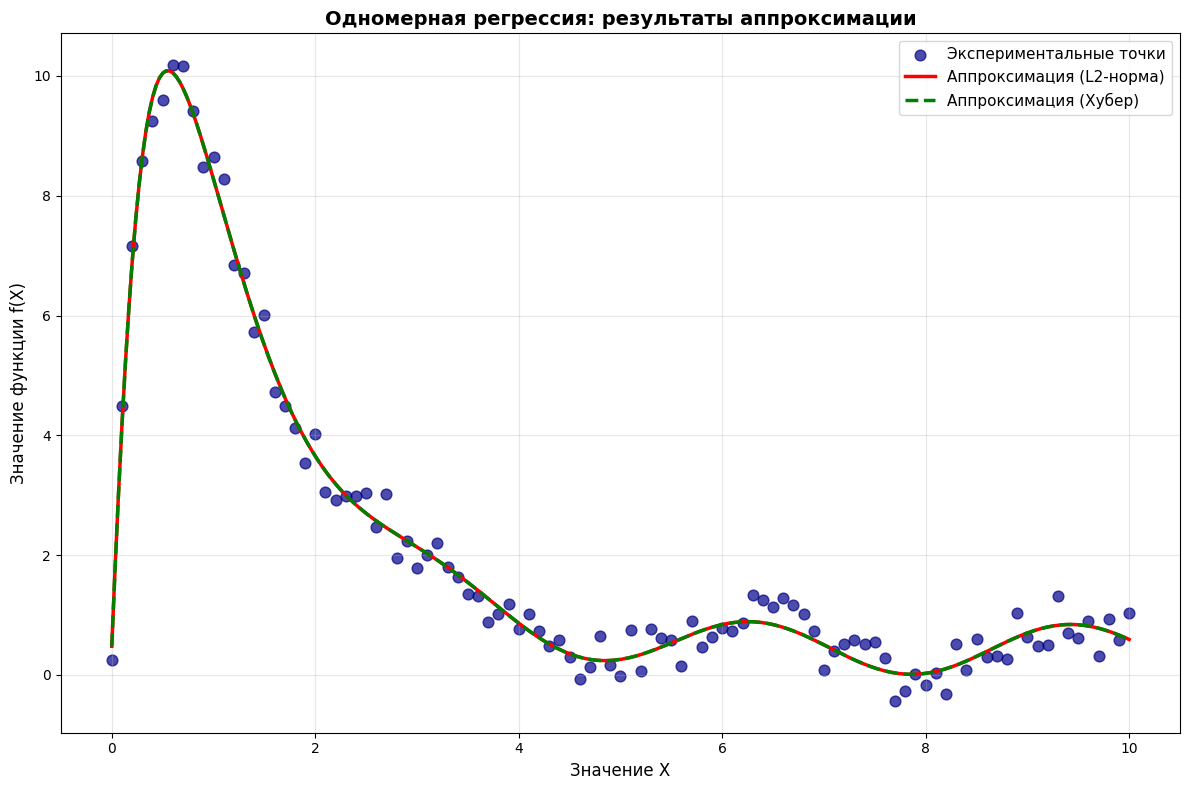

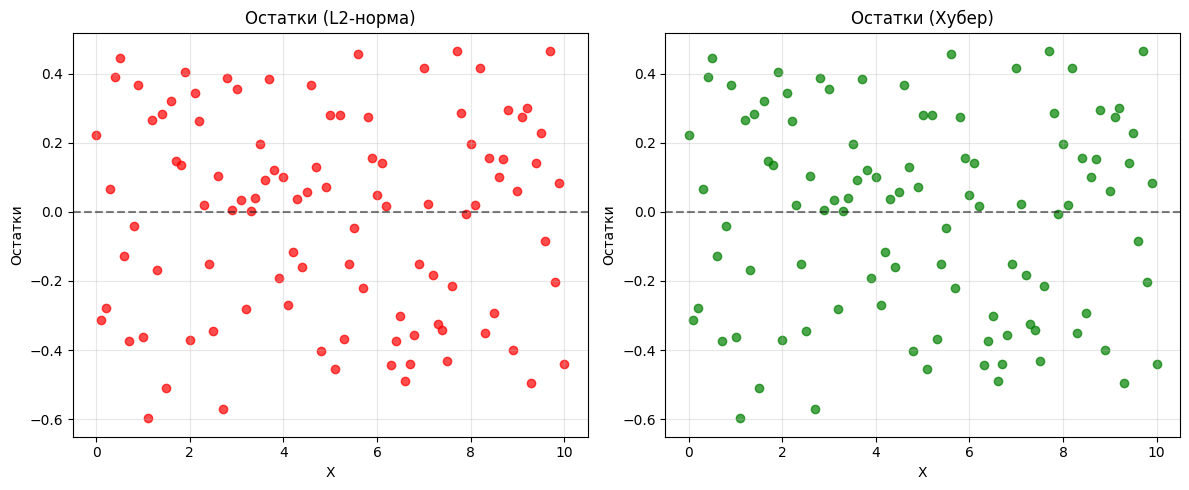


=== МНОГОМЕРНАЯ РЕГРЕССИЯ ===

Исходные данные:
Количество точек: 1681
X1: от -2.000 до 2.000
X2: от -2.000 до 2.000
F: от -1.081 до 1.053

Оптимизация с L2-нормой:
Оптимальные параметры: p1=0.982192, p2=0.164237
Сумма квадратов ошибок: 211.706105
Успешность оптимизации: True
Количество итераций: 11

Оптимизация с функцией потерь Хубера (δ=1.0):
Оптимальные параметры: p1=0.981752, p2=0.168051
Функция потерь Хубера: 105.482495
Успешность оптимизации: True
Количество итераций: 10


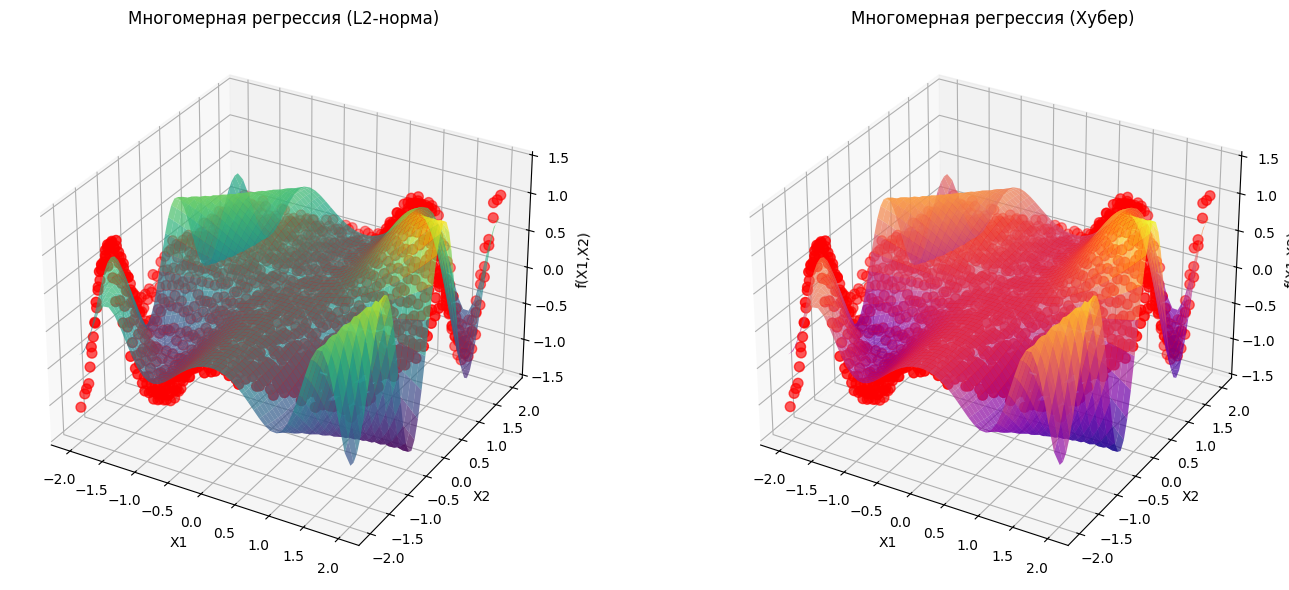


=== СТАТИСТИЧЕСКИЙ АНАЛИЗ ===

Одномерная модель:
MSE (L2): 0.084435
RMSE (L2): 0.290577
R² (L2): 0.988678
Максимальная абсолютная ошибка (L2): 0.597880

Многомерная модель:
MSE (L2): 0.125941
RMSE (L2): 0.354881
R² (L2): -0.047215
Максимальная абсолютная ошибка (L2): 1.389826

Сравнение функций потерь для одномерной модели:
δ=0.5: Потери Хубера=4.255728, Параметры=[2.1259644  2.96659958 0.71483765]
δ=1.0: Потери Хубера=4.263965, Параметры=[2.11802526 2.96922658 0.72197264]
δ=1.5: Потери Хубера=4.263965, Параметры=[2.11802526 2.96922658 0.7219728 ]
δ=2.0: Потери Хубера=4.263965, Параметры=[2.11802529 2.96922657 0.72197302]

Сравнение функций потерь для многомерной модели:
δ=0.5: Потери Хубера=93.202395, Параметры=[0.9812587 0.1937076]
δ=1.0: Потери Хубера=105.482495, Параметры=[0.98175181 0.16805081]
δ=1.5: Потери Хубера=105.853053, Параметры=[0.98219189 0.16423679]
δ=2.0: Потери Хубера=105.853053, Параметры=[0.98219189 0.16423678]


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


data_1 = pd.read_csv("fit-one.csv")
data_many = pd.read_csv("fit-many.csv")

def model_fun_1(p, x):
    p1, p2, p3 = p
    return np.arctan(p1 * x) * np.exp(-(x - p2)) + np.cos(x)**2 * np.sin(1/(1 + np.exp(-p3*x)))

def model_fun_many(p, x, y):
    p1, p2 = p
    return np.sin(p1 * x**2 * y) * np.exp(p2 * (x - y**2))

def sse_1(p):
    pred = model_fun_1(p, data_1['X'].values)
    return np.sum((pred - data_1['F'].values)**2)

def sse_many(p):
    pred = model_fun_many(p, data_many['X1'].values, data_many['X2'].values)
    return np.sum((pred - data_many['F'].values)**2)

def huber_loss_1(p, delta=1.0):
    residuals = model_fun_1(p, data_1['X'].values) - data_1['F'].values
    return np.sum(np.where(np.abs(residuals) <= delta, 
                          0.5 * residuals**2, 
                          delta * np.abs(residuals) - 0.5 * delta**2))

def huber_loss_many(p, delta=1.0):
    residuals = model_fun_many(p, data_many['X1'].values, data_many['X2'].values) - data_many['F'].values
    return np.sum(np.where(np.abs(residuals) <= delta, 
                          0.5 * residuals**2, 
                          delta * np.abs(residuals) - 0.5 * delta**2))

p0_1 = np.array([0.5, 1.0, 1.0])
p0_many = np.array([1.0, 0.0])

print("=== ОДНОМЕРНАЯ РЕГРЕССИЯ ===")
print("\nИсходные данные:")
print(f"Количество точек: {len(data_1)}")
print(f"X: от {data_1['X'].min():.3f} до {data_1['X'].max():.3f}")
print(f"F: от {data_1['F'].min():.3f} до {data_1['F'].max():.3f}")

result_1_l2 = minimize(sse_1, p0_1, method='BFGS')
print(f"\nОптимизация с L2-нормой:")
print(f"Оптимальные параметры: p1={result_1_l2.x[0]:.6f}, p2={result_1_l2.x[1]:.6f}, p3={result_1_l2.x[2]:.6f}")
print(f"Сумма квадратов ошибок: {result_1_l2.fun:.6f}")
print(f"Успешность оптимизации: {result_1_l2.success}")
print(f"Количество итераций: {result_1_l2.nit}")

result_1_huber = minimize(lambda p: huber_loss_1(p, delta=1.0), p0_1, method='BFGS')
print(f"\nОптимизация с функцией потерь Хубера (δ=1.0):")
print(f"Оптимальные параметры: p1={result_1_huber.x[0]:.6f}, p2={result_1_huber.x[1]:.6f}, p3={result_1_huber.x[2]:.6f}")
print(f"Функция потерь Хубера: {result_1_huber.fun:.6f}")
print(f"Успешность оптимизации: {result_1_huber.success}")
print(f"Количество итераций: {result_1_huber.nit}")

x_grid = np.linspace(data_1['X'].min(), data_1['X'].max(), 300)
y_pred_l2 = model_fun_1(result_1_l2.x, x_grid)
y_pred_huber = model_fun_1(result_1_huber.x, x_grid)

plt.figure(figsize=(12, 8))
plt.scatter(data_1['X'], data_1['F'], c='darkblue', s=60, alpha=0.7, edgecolors='navy', linewidth=1, label='Экспериментальные точки')
plt.plot(x_grid, y_pred_l2, 'r-', linewidth=2.5, label='Аппроксимация (L2-норма)')
plt.plot(x_grid, y_pred_huber, 'g--', linewidth=2.5, label='Аппроксимация (Хубер)')
plt.xlabel('Значение X', fontsize=12)
plt.ylabel('Значение функции f(X)', fontsize=12)
plt.title('Одномерная регрессия: результаты аппроксимации', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

residuals_l2 = model_fun_1(result_1_l2.x, data_1['X'].values) - data_1['F'].values
residuals_huber = model_fun_1(result_1_huber.x, data_1['X'].values) - data_1['F'].values

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_1['X'], residuals_l2, c='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Остатки')
plt.title('Остатки (L2-норма)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(data_1['X'], residuals_huber, c='green', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Остатки')
plt.title('Остатки (Хубер)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== МНОГОМЕРНАЯ РЕГРЕССИЯ ===")
print("\nИсходные данные:")
print(f"Количество точек: {len(data_many)}")
print(f"X1: от {data_many['X1'].min():.3f} до {data_many['X1'].max():.3f}")
print(f"X2: от {data_many['X2'].min():.3f} до {data_many['X2'].max():.3f}")
print(f"F: от {data_many['F'].min():.3f} до {data_many['F'].max():.3f}")

result_many_l2 = minimize(sse_many, p0_many, method='BFGS')
print(f"\nОптимизация с L2-нормой:")
print(f"Оптимальные параметры: p1={result_many_l2.x[0]:.6f}, p2={result_many_l2.x[1]:.6f}")
print(f"Сумма квадратов ошибок: {result_many_l2.fun:.6f}")
print(f"Успешность оптимизации: {result_many_l2.success}")
print(f"Количество итераций: {result_many_l2.nit}")

result_many_huber = minimize(lambda p: huber_loss_many(p, delta=1.0), p0_many, method='BFGS')
print(f"\nОптимизация с функцией потерь Хубера (δ=1.0):")
print(f"Оптимальные параметры: p1={result_many_huber.x[0]:.6f}, p2={result_many_huber.x[1]:.6f}")
print(f"Функция потерь Хубера: {result_many_huber.fun:.6f}")
print(f"Успешность оптимизации: {result_many_huber.success}")
print(f"Количество итераций: {result_many_huber.nit}")

x_seq = np.linspace(data_many['X1'].min(), data_many['X1'].max(), 50)
y_seq = np.linspace(data_many['X2'].min(), data_many['X2'].max(), 50)
X_grid, Y_grid = np.meshgrid(x_seq, y_seq)
Z_grid_l2 = model_fun_many(result_many_l2.x, X_grid, Y_grid)
Z_grid_huber = model_fun_many(result_many_huber.x, X_grid, Y_grid)

fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_grid, Y_grid, Z_grid_l2, alpha=0.7, cmap='viridis')
ax1.scatter(data_many['X1'], data_many['X2'], data_many['F'], c='red', s=50)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('f(X1,X2)')
ax1.set_title('Многомерная регрессия (L2-норма)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_grid, Y_grid, Z_grid_huber, alpha=0.7, cmap='plasma')
ax2.scatter(data_many['X1'], data_many['X2'], data_many['F'], c='red', s=50)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('f(X1,X2)')
ax2.set_title('Многомерная регрессия (Хубер)')

plt.tight_layout()
plt.show()

fig_plotly_l2 = go.Figure(data=[
    go.Surface(x=x_seq, y=y_seq, z=Z_grid_l2, colorscale='Viridis', opacity=0.7, name='Аппроксимация L2'),
    go.Scatter3d(x=data_many['X1'], y=data_many['X2'], z=data_many['F'], 
                mode='markers', marker=dict(size=8, color='red'), name='Данные')
])
fig_plotly_l2.update_layout(title='Многомерная регрессия (L2-норма)', 
                           scene=dict(xaxis_title='X1', yaxis_title='X2', zaxis_title='f(X1,X2)'))
fig_plotly_l2.show()

fig_plotly_huber = go.Figure(data=[
    go.Surface(x=x_seq, y=y_seq, z=Z_grid_huber, colorscale='Plasma', opacity=0.7, name='Аппроксимация Хубер'),
    go.Scatter3d(x=data_many['X1'], y=data_many['X2'], z=data_many['F'], 
                mode='markers', marker=dict(size=8, color='red'), name='Данные')
])
fig_plotly_huber.update_layout(title='Многомерная регрессия (функция потерь Хубера)', 
                              scene=dict(xaxis_title='X1', yaxis_title='X2', zaxis_title='f(X1,X2)'))
fig_plotly_huber.show()

print("\n=== СТАТИСТИЧЕСКИЙ АНАЛИЗ ===")

mse_1_l2 = result_1_l2.fun / len(data_1)
mse_many_l2 = result_many_l2.fun / len(data_many)

r2_1_l2 = 1 - np.sum(residuals_l2**2) / np.sum((data_1['F'] - np.mean(data_1['F']))**2)
r2_many_l2 = 1 - result_many_l2.fun / np.sum((data_many['F'] - np.mean(data_many['F']))**2)

print(f"\nОдномерная модель:")
print(f"MSE (L2): {mse_1_l2:.6f}")
print(f"RMSE (L2): {np.sqrt(mse_1_l2):.6f}")
print(f"R² (L2): {r2_1_l2:.6f}")
print(f"Максимальная абсолютная ошибка (L2): {np.max(np.abs(residuals_l2)):.6f}")

print(f"\nМногомерная модель:")
print(f"MSE (L2): {mse_many_l2:.6f}")
print(f"RMSE (L2): {np.sqrt(mse_many_l2):.6f}")
print(f"R² (L2): {r2_many_l2:.6f}")

residuals_many_l2 = model_fun_many(result_many_l2.x, data_many['X1'].values, data_many['X2'].values) - data_many['F'].values
print(f"Максимальная абсолютная ошибка (L2): {np.max(np.abs(residuals_many_l2)):.6f}")

delta_values = [0.5, 1.0, 1.5, 2.0]
print(f"\nСравнение функций потерь для одномерной модели:")
for delta in delta_values:
    result_delta = minimize(lambda p: huber_loss_1(p, delta=delta), p0_1, method='BFGS')
    if result_delta.success:
        print(f"δ={delta}: Потери Хубера={result_delta.fun:.6f}, Параметры={result_delta.x}")

print(f"\nСравнение функций потерь для многомерной модели:")
for delta in delta_values:
    result_delta = minimize(lambda p: huber_loss_many(p, delta=delta), p0_many, method='BFGS')
    if result_delta.success:
        print(f"δ={delta}: Потери Хубера={result_delta.fun:.6f}, Параметры={result_delta.x}")

=== ОЦЕНКА ПАРАМЕТРОВ МНОГОМЕРНОГО НОРМАЛЬНОГО РАСПРЕДЕЛЕНИЯ ===
Количество наблюдений: 10000
Данные:
       X      Y
0  2.275  4.315
1  3.030  9.566
2  1.285  4.231
3  2.224  3.730
4  2.926  6.266

Описательная статистика:
                  X             Y
count  10000.000000  10000.000000
mean       2.001415      4.968912
std        1.003230      1.733675
min       -1.689000     -2.478000
25%        1.333000      3.784000
50%        1.991000      4.963000
75%        2.674250      6.156250
max        5.702000     11.452000

=== АНАЛИТИЧЕСКОЕ РЕШЕНИЕ (MLE) ===
Оценка вектора средних μ:
μ₁ = 2.001415
μ₂ = 4.968912

Оценка ковариационной матрицы Σ:
σ₁ (Var(X)) = 1.006369
σ₂ (Cov(X,Y)) = 0.310150
σ₃ (Var(Y)) = 3.005330

Ковариационная матрица:
[[1.00636922 0.31015013]
 [0.31015013 3.00532978]]

=== ЧИСЛЕННАЯ ОПТИМИЗАЦИЯ (MLE) ===
Статус оптимизации: True
Количество итераций: 1
Значение функции: 33750.843831

Оптимальные параметры:
μ₁ = 2.001417
μ₂ = 4.968913
σ₁ = 1.006380
σ₂ = 0.310202
σ₃

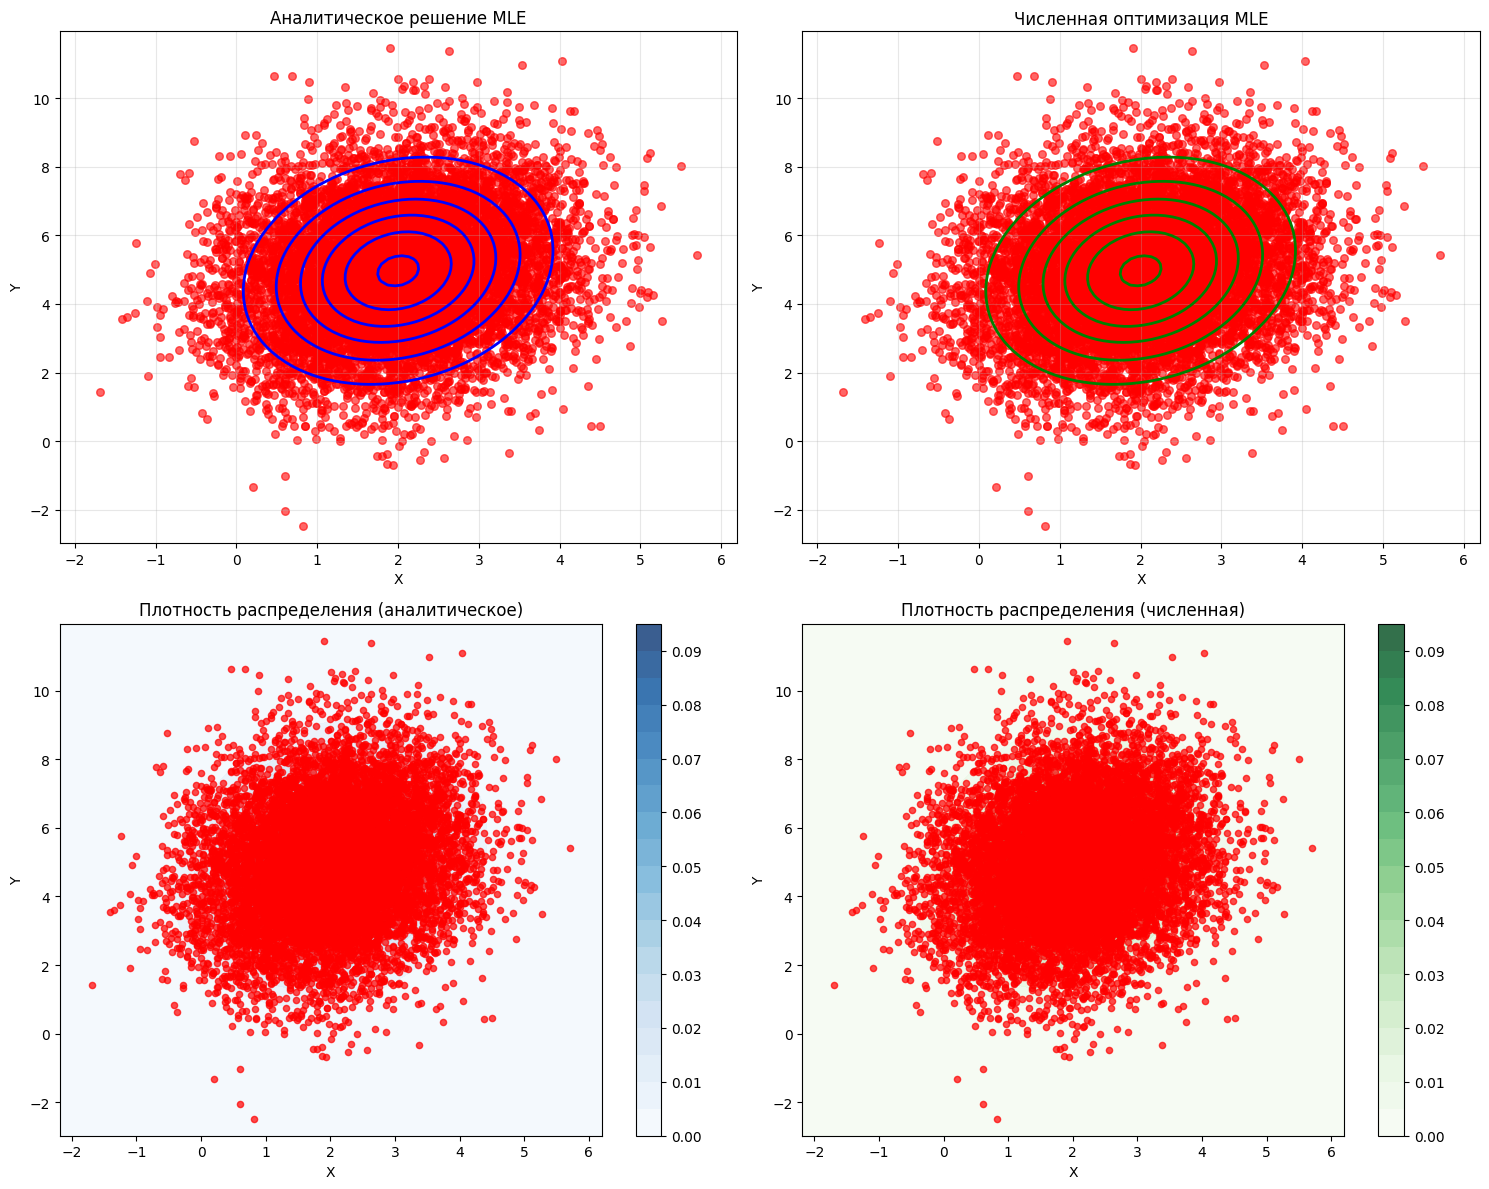


=== ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ===
Коэффициент корреляции:
Аналитический: 0.178339
Численный: 0.178360

Собственные значения ковариационной матрицы:
Аналитический метод: [0.95935347 3.05234552]
Численный метод: [0.95935458 3.05262556]

Определитель ковариационной матрицы:
Аналитический: 2.928278
Численный: 2.928550

Лог-правдоподобие:
Аналитический метод: -33750.843810
Численный метод: -33750.843831
Разность: 0.00002128

Информационные критерии:
AIC (аналитический): 67511.687620
AIC (численный): 67511.687663
BIC (аналитический): 67547.739322
BIC (численный): 67547.739364


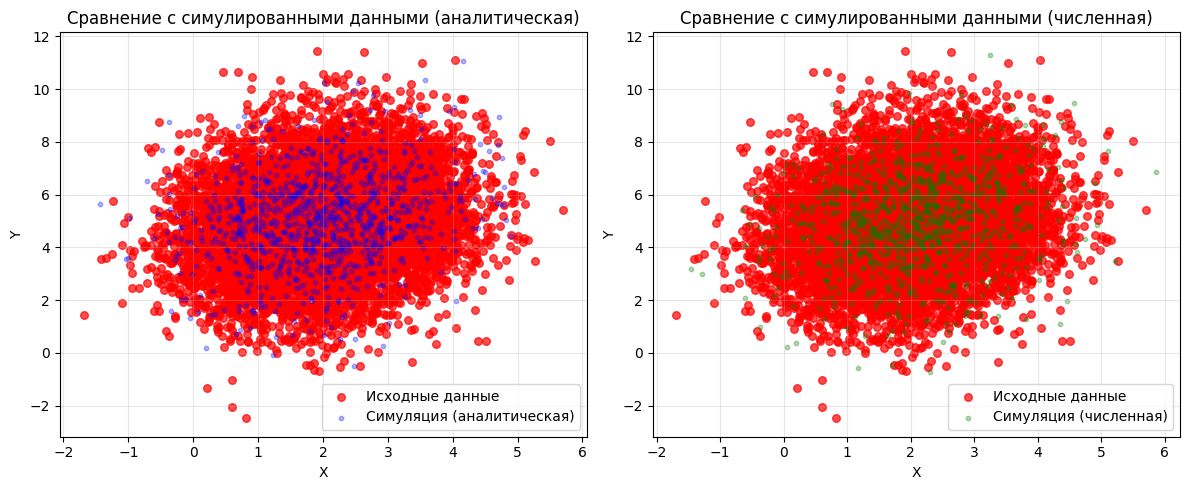


=== ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ ===
Стандартные ошибки параметров:
SE(μ₁) = 0.015374
SE(μ₂) = nan
SE(σ₁) = 0.021022
SE(σ₂) = 0.018736
SE(σ₃) = nan

95% доверительные интервалы:
μ₁: [1.971284, 2.031549]
μ₂: [nan, nan]
σ₁: [0.965176, 1.047584]
σ₂: [0.273479, 0.346926]
σ₃: [nan, nan]


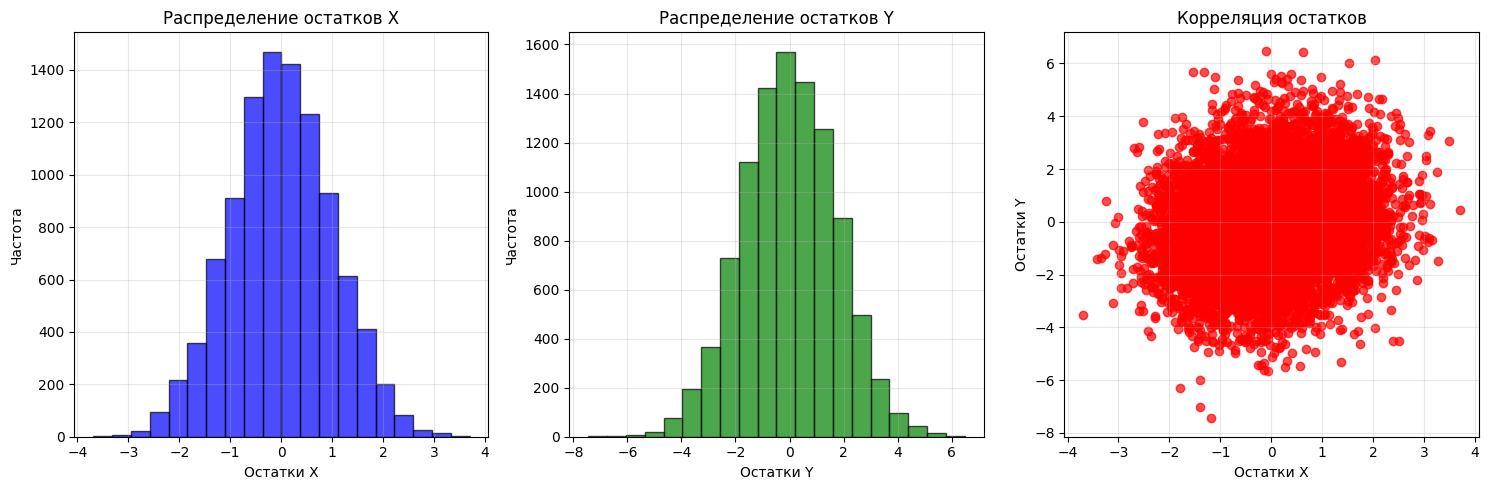


=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===
Оценки параметров многомерного нормального распределения:
μ = [2.001417, 4.968913]ᵀ
Σ = [[1.006380, 0.310202]
     [0.310202, 3.005600]]

Коэффициент корреляции: 0.178360
Логарифм правдоподобия: -33750.843831


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("multivariate.csv")
N = len(data)

print("=== ОЦЕНКА ПАРАМЕТРОВ МНОГОМЕРНОГО НОРМАЛЬНОГО РАСПРЕДЕЛЕНИЯ ===")
print(f"Количество наблюдений: {N}")
print(f"Данные:")
print(data.head())
print(f"\nОписательная статистика:")
print(data.describe())

mu_hat_analytic = data[['X', 'Y']].mean().values
cov_hat_analytic = data[['X', 'Y']].cov().values * (N - 1) / N

sigma1_analytic = cov_hat_analytic[0, 0]
sigma2_analytic = cov_hat_analytic[0, 1]
sigma3_analytic = cov_hat_analytic[1, 1]

print(f"\n=== АНАЛИТИЧЕСКОЕ РЕШЕНИЕ (MLE) ===")
print(f"Оценка вектора средних μ:")
print(f"μ₁ = {mu_hat_analytic[0]:.6f}")
print(f"μ₂ = {mu_hat_analytic[1]:.6f}")
print(f"\nОценка ковариационной матрицы Σ:")
print(f"σ₁ (Var(X)) = {sigma1_analytic:.6f}")
print(f"σ₂ (Cov(X,Y)) = {sigma2_analytic:.6f}")
print(f"σ₃ (Var(Y)) = {sigma3_analytic:.6f}")
print(f"\nКовариационная матрица:")
print(cov_hat_analytic)

def neg_log_likelihood(params):
    mu1, mu2, sigma1, sigma2, sigma3 = params
    
    if sigma1 <= 0 or sigma3 <= 0:
        return 1e10
    
    cov_matrix = np.array([[sigma1, sigma2], [sigma2, sigma3]])
    det_cov = np.linalg.det(cov_matrix)
    
    if det_cov <= 0:
        return 1e10
    
    try:
        inv_cov = np.linalg.inv(cov_matrix)
    except:
        return 1e10
    
    mu = np.array([mu1, mu2])
    log_likelihood = 0
    
    for i in range(N):
        x_vec = data.iloc[i][['X', 'Y']].values
        diff = x_vec - mu
        log_likelihood += -0.5 * np.dot(diff.T, np.dot(inv_cov, diff)) - 0.5 * np.log(det_cov) - np.log(2 * np.pi)
    
    return -log_likelihood

initial_params = [
    data['X'].mean(),
    data['Y'].mean(),
    data['X'].var(),
    data['X'].cov(data['Y']),
    data['Y'].var()
]

bounds = [
    (None, None),
    (None, None),
    (1e-6, None),
    (None, None),
    (1e-6, None)
]

result = minimize(neg_log_likelihood, initial_params, method='L-BFGS-B', bounds=bounds)

mu1_opt, mu2_opt, sigma1_opt, sigma2_opt, sigma3_opt = result.x
cov_opt = np.array([[sigma1_opt, sigma2_opt], [sigma2_opt, sigma3_opt]])

print(f"\n=== ЧИСЛЕННАЯ ОПТИМИЗАЦИЯ (MLE) ===")
print(f"Статус оптимизации: {result.success}")
print(f"Количество итераций: {result.nit}")
print(f"Значение функции: {result.fun:.6f}")

print(f"\nОптимальные параметры:")
print(f"μ₁ = {mu1_opt:.6f}")
print(f"μ₂ = {mu2_opt:.6f}")
print(f"σ₁ = {sigma1_opt:.6f}")
print(f"σ₂ = {sigma2_opt:.6f}")
print(f"σ₃ = {sigma3_opt:.6f}")

print(f"\nОптимальная ковариационная матрица:")
print(cov_opt)

print(f"\n=== СРАВНЕНИЕ МЕТОДОВ ===")
print(f"Разность средних:")
print(f"Δμ₁ = {abs(mu_hat_analytic[0] - mu1_opt):.8f}")
print(f"Δμ₂ = {abs(mu_hat_analytic[1] - mu2_opt):.8f}")
print(f"Разность ковариационных параметров:")
print(f"Δσ₁ = {abs(sigma1_analytic - sigma1_opt):.8f}")
print(f"Δσ₂ = {abs(sigma2_analytic - sigma2_opt):.8f}")
print(f"Δσ₃ = {abs(sigma3_analytic - sigma3_opt):.8f}")

x_min, x_max = data['X'].min() - 0.5, data['X'].max() + 0.5
y_min, y_max = data['Y'].min() - 0.5, data['Y'].max() + 0.5

x_seq = np.linspace(x_min, x_max, 100)
y_seq = np.linspace(y_min, y_max, 100)
X_grid, Y_grid = np.meshgrid(x_seq, y_seq)

pos = np.dstack((X_grid, Y_grid))
rv_analytic = multivariate_normal(mu_hat_analytic, cov_hat_analytic)
rv_optimized = multivariate_normal([mu1_opt, mu2_opt], cov_opt)

density_analytic = rv_analytic.pdf(pos)
density_optimized = rv_optimized.pdf(pos)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(data['X'], data['Y'], c='red', alpha=0.6, s=30)
contour1 = axes[0, 0].contour(X_grid, Y_grid, density_analytic, colors='blue', linewidths=2)
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Аналитическое решение MLE')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(data['X'], data['Y'], c='red', alpha=0.6, s=30)
contour2 = axes[0, 1].contour(X_grid, Y_grid, density_optimized, colors='green', linewidths=2)
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].set_title('Численная оптимизация MLE')
axes[0, 1].grid(True, alpha=0.3)

im1 = axes[1, 0].contourf(X_grid, Y_grid, density_analytic, levels=20, cmap='Blues', alpha=0.8)
axes[1, 0].scatter(data['X'], data['Y'], c='red', alpha=0.7, s=20)
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].set_title('Плотность распределения (аналитическое)')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].contourf(X_grid, Y_grid, density_optimized, levels=20, cmap='Greens', alpha=0.8)
axes[1, 1].scatter(data['X'], data['Y'], c='red', alpha=0.7, s=20)
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
axes[1, 1].set_title('Плотность распределения (численная)')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.show()

correlation_analytic = sigma2_analytic / np.sqrt(sigma1_analytic * sigma3_analytic)
correlation_optimized = sigma2_opt / np.sqrt(sigma1_opt * sigma3_opt)

eigenvals_analytic, eigenvecs_analytic = np.linalg.eig(cov_hat_analytic)
eigenvals_optimized, eigenvecs_optimized = np.linalg.eig(cov_opt)

print(f"\n=== ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ===")
print(f"Коэффициент корреляции:")
print(f"Аналитический: {correlation_analytic:.6f}")
print(f"Численный: {correlation_optimized:.6f}")

print(f"\nСобственные значения ковариационной матрицы:")
print(f"Аналитический метод: {eigenvals_analytic}")
print(f"Численный метод: {eigenvals_optimized}")

print(f"\nОпределитель ковариационной матрицы:")
print(f"Аналитический: {np.linalg.det(cov_hat_analytic):.6f}")
print(f"Численный: {np.linalg.det(cov_opt):.6f}")

log_likelihood_analytic = -neg_log_likelihood([mu_hat_analytic[0], mu_hat_analytic[1], 
                                              sigma1_analytic, sigma2_analytic, sigma3_analytic])
log_likelihood_optimized = -result.fun

print(f"\nЛог-правдоподобие:")
print(f"Аналитический метод: {log_likelihood_analytic:.6f}")
print(f"Численный метод: {log_likelihood_optimized:.6f}")
print(f"Разность: {abs(log_likelihood_analytic - log_likelihood_optimized):.8f}")

n_params = 5
aic_analytic = 2 * n_params - 2 * log_likelihood_analytic
aic_optimized = 2 * n_params - 2 * log_likelihood_optimized

bic_analytic = n_params * np.log(N) - 2 * log_likelihood_analytic
bic_optimized = n_params * np.log(N) - 2 * log_likelihood_optimized

print(f"\nИнформационные критерии:")
print(f"AIC (аналитический): {aic_analytic:.6f}")
print(f"AIC (численный): {aic_optimized:.6f}")
print(f"BIC (аналитический): {bic_analytic:.6f}")
print(f"BIC (численный): {bic_optimized:.6f}")

samples_analytic = np.random.multivariate_normal(mu_hat_analytic, cov_hat_analytic, 1000)
samples_optimized = np.random.multivariate_normal([mu1_opt, mu2_opt], cov_opt, 1000)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(data['X'], data['Y'], c='red', alpha=0.7, s=30, label='Исходные данные')
plt.scatter(samples_analytic[:, 0], samples_analytic[:, 1], c='blue', alpha=0.3, s=10, label='Симуляция (аналитическая)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Сравнение с симулированными данными (аналитическая)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(data['X'], data['Y'], c='red', alpha=0.7, s=30, label='Исходные данные')
plt.scatter(samples_optimized[:, 0], samples_optimized[:, 1], c='green', alpha=0.3, s=10, label='Симуляция (численная)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Сравнение с симулированными данными (численная)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ ===")

hessian_at_optimum = np.array([
    [N/sigma1_opt, 0, -N*sigma1_opt/(2*sigma1_opt**2), -N*sigma2_opt/(2*sigma1_opt**2), 0],
    [0, N/sigma3_opt, 0, -N*sigma2_opt/(2*sigma3_opt**2), -N*sigma3_opt/(2*sigma3_opt**2)],
    [-N*sigma1_opt/(2*sigma1_opt**2), 0, N/(2*sigma1_opt**2), 0, 0],
    [-N*sigma2_opt/(2*sigma1_opt**2), -N*sigma2_opt/(2*sigma3_opt**2), 0, N/(sigma1_opt*sigma3_opt), 0],
    [0, -N*sigma3_opt/(2*sigma3_opt**2), 0, 0, N/(2*sigma3_opt**2)]
])

try:
    fisher_info = np.linalg.inv(hessian_at_optimum)
    std_errors = np.sqrt(np.diag(fisher_info))
    
    print(f"Стандартные ошибки параметров:")
    print(f"SE(μ₁) = {std_errors[0]:.6f}")
    print(f"SE(μ₂) = {std_errors[1]:.6f}")
    print(f"SE(σ₁) = {std_errors[2]:.6f}")
    print(f"SE(σ₂) = {std_errors[3]:.6f}")
    print(f"SE(σ₃) = {std_errors[4]:.6f}")
    
    z_critical = 1.96
    params_opt = [mu1_opt, mu2_opt, sigma1_opt, sigma2_opt, sigma3_opt]
    param_names = ['μ₁', 'μ₂', 'σ₁', 'σ₂', 'σ₃']
    
    print(f"\n95% доверительные интервалы:")
    for i, (param, se, name) in enumerate(zip(params_opt, std_errors, param_names)):
        ci_lower = param - z_critical * se
        ci_upper = param + z_critical * se
        print(f"{name}: [{ci_lower:.6f}, {ci_upper:.6f}]")
        
except:
    print("Не удалось вычислить доверительные интервалы из-за особенности матрицы Гессе")

residuals_x = data['X'] - mu1_opt
residuals_y = data['Y'] - mu2_opt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(residuals_x, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Остатки X')
plt.ylabel('Частота')
plt.title('Распределение остатков X')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals_y, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Остатки Y')
plt.ylabel('Частота')
plt.title('Распределение остатков Y')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(residuals_x, residuals_y, alpha=0.7, color='red')
plt.xlabel('Остатки X')
plt.ylabel('Остатки Y')
plt.title('Корреляция остатков')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")
print(f"Оценки параметров многомерного нормального распределения:")
print(f"μ = [{mu1_opt:.6f}, {mu2_opt:.6f}]ᵀ")
print(f"Σ = [[{sigma1_opt:.6f}, {sigma2_opt:.6f}]")
print(f"     [{sigma2_opt:.6f}, {sigma3_opt:.6f}]]")
print(f"\nКоэффициент корреляции: {correlation_optimized:.6f}")
print(f"Логарифм правдоподобия: {log_likelihood_optimized:.6f}")